# かがわAIゼミナール　2020
## 課題
更新日:2010/10/20

データセット：「Kickstarter Projects」  
 問題設定：クラウドファンデイングが成功するか(state)を予測する。

 https://www.kaggle.com/kemical/kickstarter-projects  
 データ:ks-projects-201801.csv

In [1]:
%matplotlib inline
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数

### CSVファイルの中身を確認する｡  

|項目|説明|目的変数|
|-|-|-|
|ID|-|-|
|name|-|-|
|category|-|-|
|main_category|category of campaign|-|
|currency|currency used to support:通貨|-|
|deadline|deadline for crowdfunding:終了|-|
|goal|目標金額|-|
|launched|date launched:開始|-|
|pledged|amount pledged by "crowd"	集まったお金|-|		
|state|結果|〇|
|backers|後援者,パトロン|-|		
|country|-|-|
|usd pledged|-|-|				
|usd_pledged_real|-|-|
|usd_goal_real|USDに換算した目標金額|-|


In [2]:
#CSVを読み込む
ks_proj = pd.read_csv("../kaggle/ks-projects-201801_csv/ks-projects-201801.csv")

In [3]:
#内容確認
ks_proj.info()
display(ks_proj.head())
ks_proj.describe(include='O')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


,name,category,main_category,currency,deadline,launched,state,country
count,378657,378661,378661,378661,378661,378661,378661,378661
unique,375764,159,15,14,3164,378089,6,23
top,New EP/Music Development,Product Design,Film & Video,USD,2014-08-08,1970-01-01 01:00:00,failed,US
freq,41,22314,63585,295365,705,7,197719,292627


In [4]:
#stateのunipueが6あるため内容を確認
ks_proj['state'].unique()

array(['failed', 'canceled', 'successful', 'live', 'undefined',
       'suspended'], dtype=object)

今回は'failed', 'successful'のロジスティクス回帰とし、それ以外は削除する。

In [5]:
#ks2を作成
ks2= ks_proj.copy()
#state列が'failed','successful'の行を抽出する。
ks2 = ks2[ks2['state'].isin(['failed','successful'])]
#state列の'successful'を1としてフラグを立てる
ks2['state_f'] = 0
ks2.loc[ks2['state'] == 'successful', 'state_f'] = 1
display(ks2.head())
ks2.describe()
ks2.describe(include='O')

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,state_f
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00,0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00,0
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,successful,224,US,52375.0,52375.0,50000.00,1


,name,category,main_category,currency,deadline,launched,state,country
count,331672,331675,331675,331675,331675,331675,331675,331675
unique,329594,159,15,14,3102,331255,2,23
top,New EP/Music Development,Product Design,Film & Video,USD,2014-08-08,2016-02-29 17:35:57,failed,US
freq,15,18680,56527,261511,612,2,197719,261360


In [6]:
ks2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 16 columns):
ID                  331675 non-null int64
name                331672 non-null object
category            331675 non-null object
main_category       331675 non-null object
currency            331675 non-null object
deadline            331675 non-null object
goal                331675 non-null float64
launched            331675 non-null object
pledged             331675 non-null float64
state               331675 non-null object
backers             331675 non-null int64
country             331675 non-null object
usd pledged         331465 non-null float64
usd_pledged_real    331675 non-null float64
usd_goal_real       331675 non-null float64
state_f             331675 non-null int64
dtypes: float64(5), int64(3), object(8)
memory usage: 43.0+ MB


## 説明変数の整理

以下は結果のデータのため説明変数としては使用しない  
pledged             378661 non-null float64  
backers             378661 non-null int64  
usd pledged         374864 non-null float64  
usd_pledged_real    378661 non-null float64  

In [7]:
##結果のデータは使用しない
ks2 = ks2.drop(['pledged', 'backers','usd pledged', 'usd_pledged_real'],axis=1)

#### IDについて

In [8]:
ks2['ID'].head()

0    1000002330
1    1000003930
2    1000004038
3    1000007540
5    1000014025
Name: ID, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002289C9E9908>,
      dtype=object)

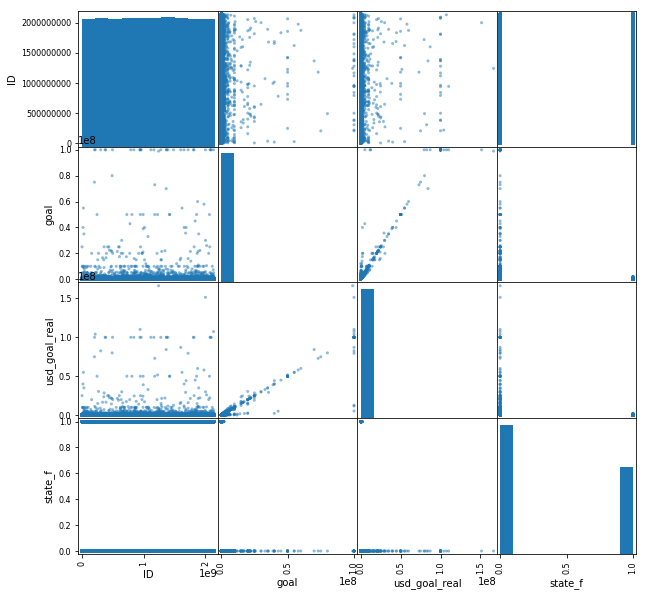

In [9]:
pd.plotting.scatter_matrix(ks2, figsize=(10,10))

IDは成否とは関係ないため説明変数とはしない。

#### nameについて
nameと成否の関係を確認する。

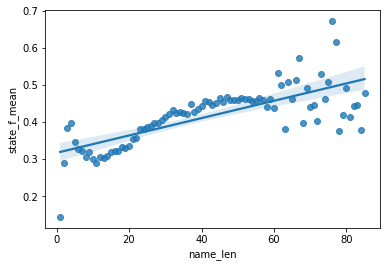

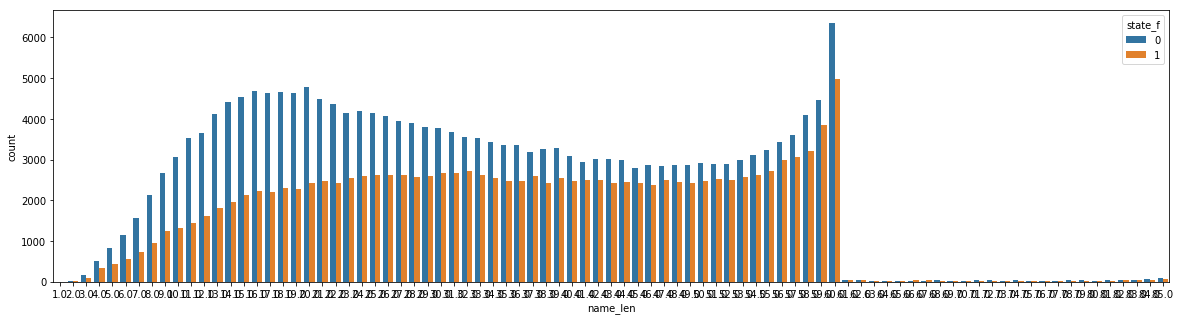

In [10]:
ks2["name_len"] = ks2.name.str.len()
#文字数でグループ化して文字数ごとの成功フラグの平均値をとることで文字数ごとの成功率を出す。
z = ks2.groupby('name_len',as_index=False).state_f.mean()
z =z.rename(columns={'state_f': 'state_f_mean'})
sns.regplot(x='name_len',y='state_f_mean',data=z)

plt.figure(figsize=(20,5))
sns.countplot(data=ks2, x='name_len',hue='state_f')

文字数が多いほうが成功率が高いことが分かった。  
ただし、61文字以上はサンプル数が60文字以下に比べて極端に少ない

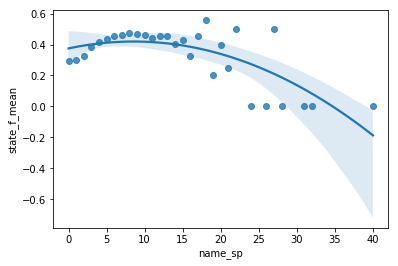

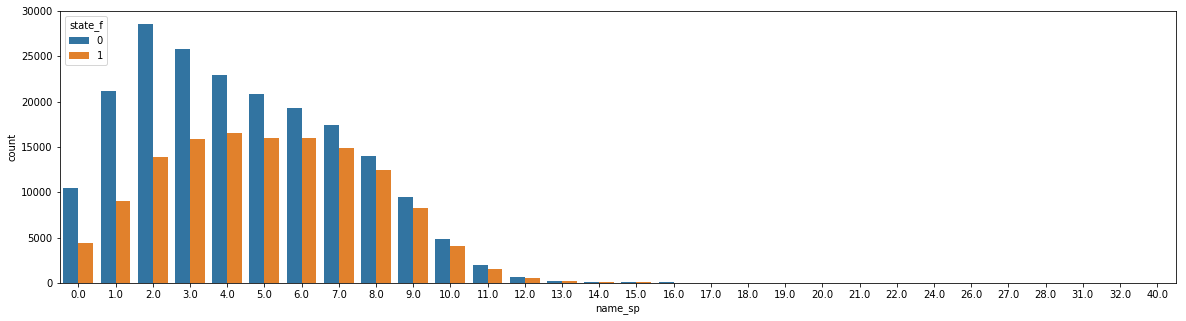

In [11]:
ks2["name_sp"] = ks2.name.str.count(" ")
z = ks2.groupby('name_sp',as_index=False).state_f.mean()
z =z.rename(columns={'state_f': 'state_f_mean'})
sns.regplot(x='name_sp',y='state_f_mean',data=z, order=2, truncate=True)

plt.figure(figsize=(20,5))
sns.countplot(data=ks2, x='name_sp',hue='state_f')


nameに含まれるスペースの数が15個以上になると成功数が下がっていくが  
15個以上はサンプル数が少ない

<Figure size 1800x1080 with 0 Axes>

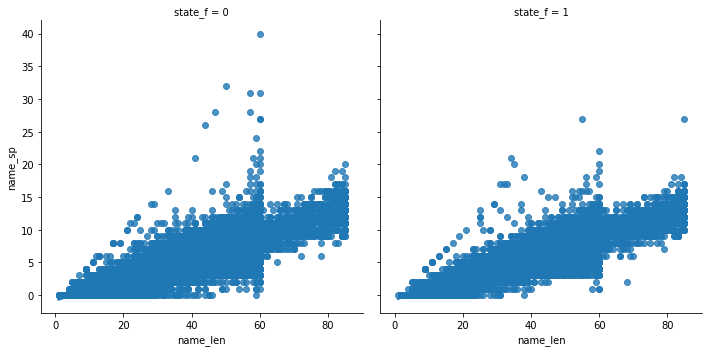

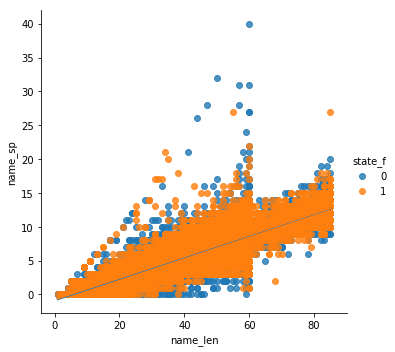

In [12]:
plt.figure(figsize=(25,15))
sns.lmplot(x='name_len',y='name_sp',col='state_f',data=ks2)
sns.lmplot(x='name_len',y='name_sp',hue='state_f',data=ks2)

文字数とスペースの数を失敗=0と成功=1で散布図にした。  
文字数とスペースの数は比例しており、成功と失敗で大きな傾向の違いはないと思われる。

nameに関連する数値は文字数のみを説明変数とする。

#### launched,deadlineについて  
launched(開始）とdeadline(終了）の差分をとって期間を抽出する。  
objectからdatetimeに変換する。

In [13]:
##時分秒を削除する
##object→datetimeに変更（処理に時間がかかる）
ks2['launched'] = pd.to_datetime(ks2['launched'])
ks2['deadline'] = pd.to_datetime(ks2['deadline'])
ks2['days'] = (ks2['deadline'] - ks2['launched']).dt.days

ks2['days'].value_counts()

29    148478
59     27969
44     15241
30     11724
34      8619
39      8594
31      6467
20      6125
19      6059
28      5540
24      5518
32      5070
14      4860
27      4848
13      3848
33      3210
35      3017
26      2654
21      2461
25      2373
23      2305
36      2279
49      2193
9       2081
22      2061
37      1908
45      1806
41      1731
38      1682
6       1642
       ...  
2        194
1        129
62       124
65       107
87       105
64       105
69        98
0         92
63        83
70        82
74        81
75        75
71        74
66        69
67        61
86        61
79        59
85        59
68        57
84        56
80        49
77        49
72        49
82        47
83        47
81        46
76        45
73        43
78        35
91        22
Name: days, Length: 92, dtype: int64

#### 目標設定金額について
usd_goal_real(目標金額ドル換算）を採用する。

#### 期間と成功率  
期間と成功/失敗の数を可視化してみる。

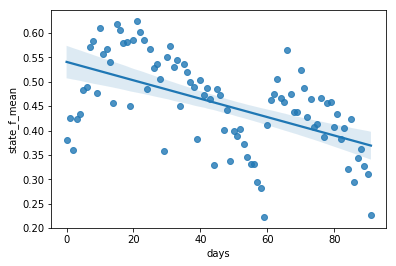

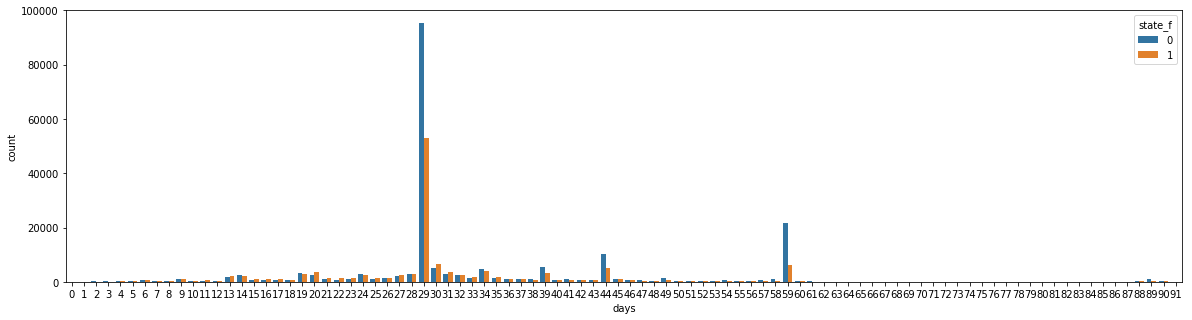

In [14]:
z = ks2.groupby('days',as_index=False).state_f.mean()
z =z.rename(columns={'state_f': 'state_f_mean'})
sns.regplot(x='days',y='state_f_mean',data=z)

plt.figure(figsize=(20,5))
sns.countplot(data=ks2, x='days',hue='state_f')

29日（およそ1か月間） が圧倒的に多い  
全体的には日数が長くなるほど成功率が低いが、そもそも数の偏りが大きい

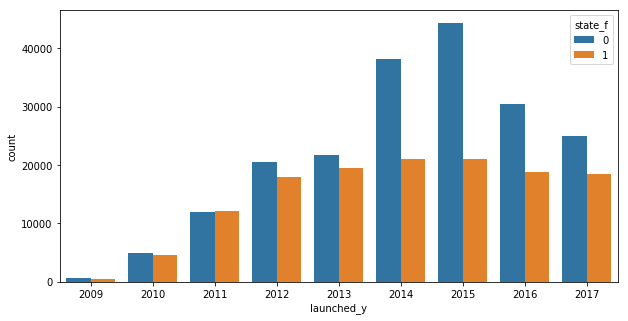

In [15]:
##年度ごとの成否を可視化する。
ks2['launched_y'] =ks2['launched'].dt.year
plt.figure(figsize=(10,5))
sns.countplot(data=ks2, x='launched_y',hue='state_f')

2014年と2015年は件数が多いが成功率が低い  
2014年と2015年は他と傾向が違うのか？

2014年,2015年と他の年度の違いを確認する。  
対象の2014年と2015年、前後の2013年と2016年を比較する。

In [16]:
#成功数はほぼ同じで失敗数が極端に多いことからfaleseの傾向を年度ごとに抜きだし確認する。
ks2_f= ks2.copy()
#state列の'failed'を1としてフラグを立てる
ks2_f['state_f'] = 0
ks2_f.loc[ks2_f['state'] == 'failed', 'state_f'] = 1
ks2013 = ks2_f[ks2_f['launched_y'].isin(['2013'])]
ks2014 = ks2_f[ks2_f['launched_y'].isin(['2014'])]
ks2015 = ks2_f[ks2_f['launched_y'].isin(['2015'])]
ks2016 = ks2_f[ks2_f['launched_y'].isin(['2016'])]

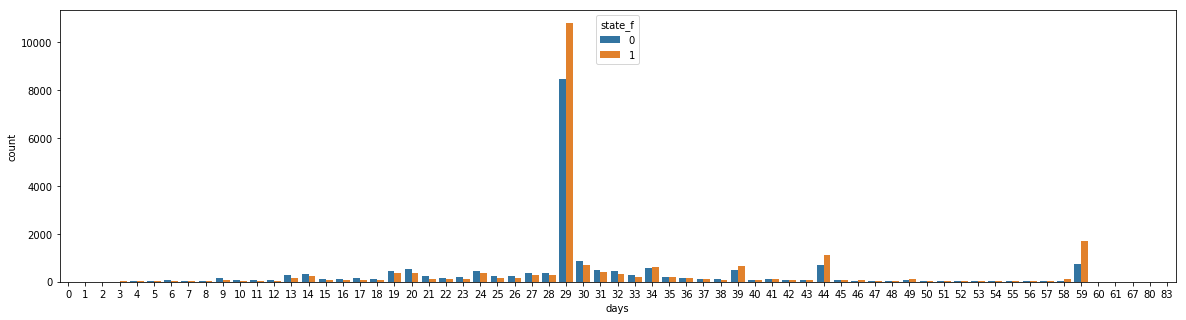

In [17]:
plt.figure(figsize=(20,5))
sns.countplot(data=ks2013, x='days',hue='state_f')

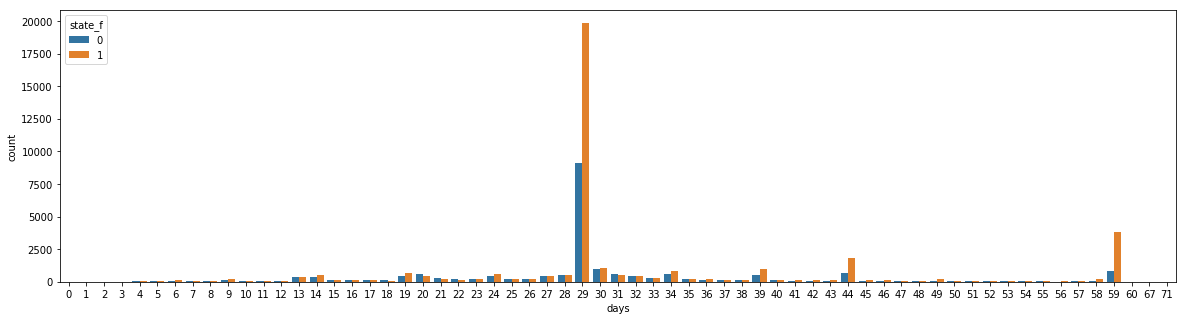

In [18]:
plt.figure(figsize=(20,5))
sns.countplot(data=ks2014, x='days',hue='state_f')

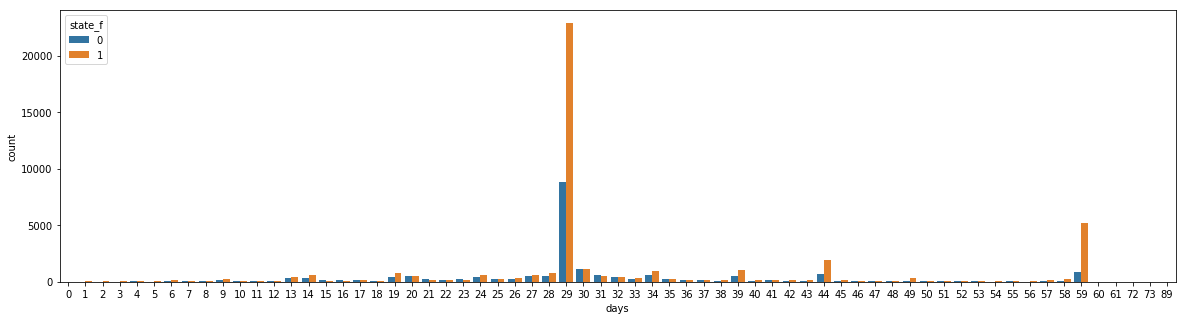

In [19]:
plt.figure(figsize=(20,5))
sns.countplot(data=ks2015, x='days',hue='state_f')

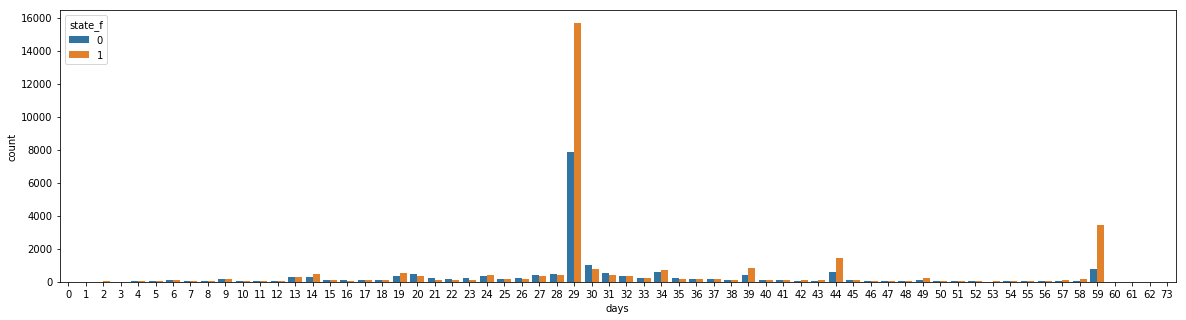

In [20]:
plt.figure(figsize=(20,5))
sns.countplot(data=ks2016, x='days',hue='state_f')

各年度とも設定期間は29日が最頻値であるが
2014,2015年ともに成功率が低い

<Figure size 2160x720 with 0 Axes>

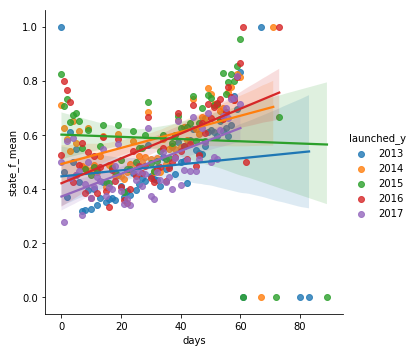

In [21]:
#各年度別の期間ごとの失敗率をプロットする。
z = ks2_f.groupby(['days','launched_y'],as_index=False).state_f.mean()
z =z.rename(columns={'state_f': 'state_f_mean'})
#z[z['launched_y'].isin(['2013','2014','2015','2016'])]
plt.figure(figsize=(30,10))
#sns.lmplot(x='days',y='state_f_mean',data=z,hue='launched_y')
sns.lmplot(x='days',y='state_f_mean',data=z[z['launched_y'].isin(['2013','2014','2015','2016','2017'])],hue='launched_y')

2015年は期間が短い場合の失敗率が他よりも高い傾向がある。

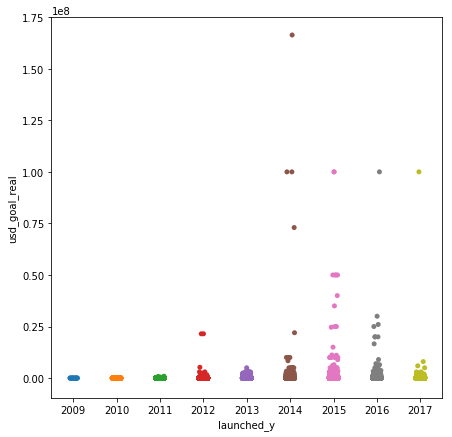

In [22]:
#各年度ごとの設定期間"29"の失敗時の目標金額をプロットする。
plt.figure(figsize=(7,7))
sns.stripplot(x='launched_y', y="usd_goal_real", data=ks2[ks2['days'].isin(['29'])&ks2['state'].isin(['failed'])])

[None]

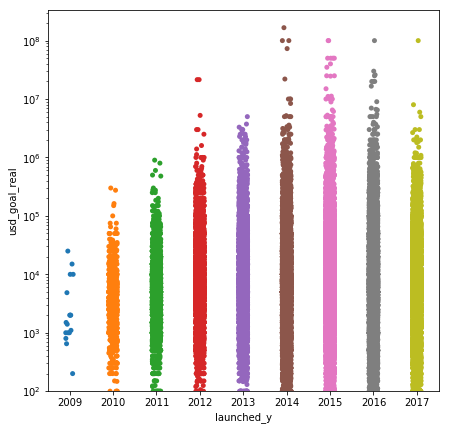

In [23]:
#各年度ごとの設定期間"29"の失敗時の目標金額をプロットする。
#目標金額が大きすぎるためy軸を対数で表現する。
plt.figure(figsize=(7,7))
goal_f = sns.stripplot(x='launched_y', y="usd_goal_real", data=ks2[ks2['days'].isin(['29'])&ks2['state'].isin(['failed'])])
goal_f.set( yscale="log") 

[None]

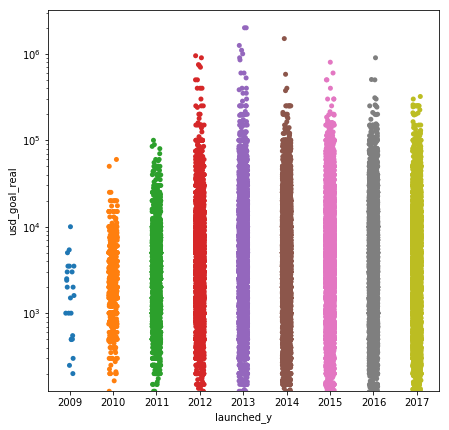

In [24]:
#各年度ごとの設定期間"29"の成功時の目標金額をプロットする。
plt.figure(figsize=(7,7))
goal_s = sns.stripplot(x='launched_y', y="usd_goal_real", data=ks2[ks2['days'].isin(['29'])&ks2['state'].isin(['successful'])])
goal_s.set( yscale="log") 

[None]

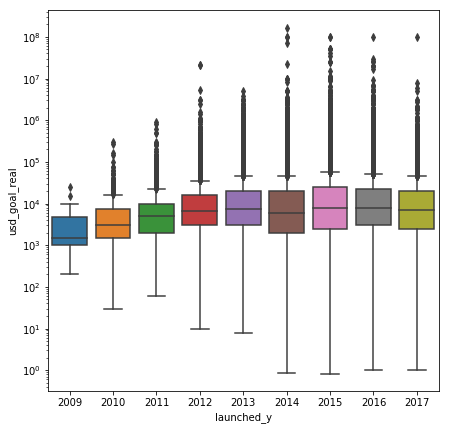

In [25]:
plt.figure(figsize=(7,7))
goal_box = sns.boxplot(x="launched_y", y="usd_goal_real", data=ks2[ks2['days'].isin(['29'])&ks2['state'].isin(['failed'])])
goal_box.set( yscale="log") 

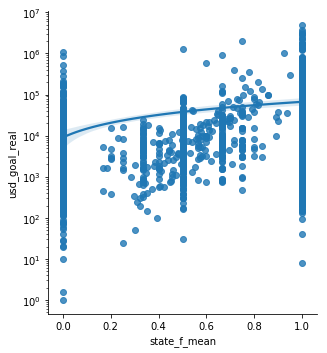

In [26]:
#年度別の期間=29の失敗率をプロットする。
z = ks2013.groupby(['days','usd_goal_real'],as_index=False).state_f.mean()
z =z.rename(columns={'state_f': 'state_f_mean'})
f_rate = sns.lmplot(x='state_f_mean',y='usd_goal_real',data=z[z['days'].isin(['29'])])
f_rate.set( yscale="log") 

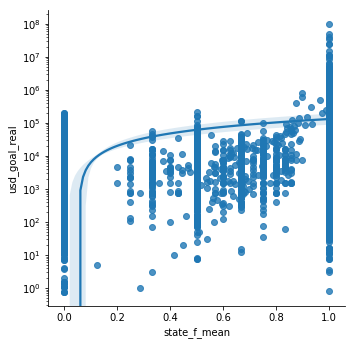

In [27]:
#年度別の期間=29の失敗率をプロットする。
z = ks2015.groupby(['days','usd_goal_real'],as_index=False).state_f.mean()
z =z.rename(columns={'state_f': 'state_f_mean'})
f_rate = sns.lmplot(x='state_f_mean',y='usd_goal_real',data=z[z['days'].isin(['29'])])
f_rate.set( yscale="log") 

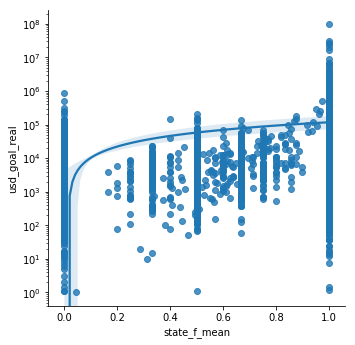

In [28]:
#年度別の期間=29の失敗率をプロットする。
z = ks2016.groupby(['days','usd_goal_real'],as_index=False).state_f.mean()
z =z.rename(columns={'state_f': 'state_f_mean'})
f_rate = sns.lmplot(x='state_f_mean',y='usd_goal_real',data=z[z['days'].isin(['29'])])
f_rate.set( yscale="log") 

2014,2015と他の年度を目標金額で比較した  
失敗時の目標金額が他の年度に比べて高く設定されている傾向があったが  
箱ひげ図を見る限り目標金額からは決定的な違いを見つけられない。

'usd_goal_real'は対数にすることで比較しやすくなる

In [29]:
import math
ks2['usd_goal_log'] = np.log(ks2['usd_goal_real'])

In [30]:
ks2.describe()

,ID,goal,usd_goal_real,state_f,name_len,name_sp,days,launched_y,usd_goal_log
count,3.316750e+05,3.316750e+05,3.316750e+05,331675.000000,331672.000000,331672.000000,331675.000000,331675.000000,331675.000000
mean,1.074271e+09,4.425157e+04,4.151000e+04,0.403877,34.220335,4.654746,32.954902,2014.180002,8.580837
std,6.191924e+08,1.117917e+06,1.108930e+06,0.490674,15.961502,2.784668,12.713329,1.930922,1.673316
min,5.971000e+03,1.000000e-02,1.000000e-02,0.000000,1.000000,0.000000,0.000000,2009.000000,-4.605170
25%,5.371725e+08,2.000000e+03,2.000000e+03,0.000000,21.000000,2.000000,29.000000,2013.000000,7.600902
50%,1.074573e+09,5.000000e+03,5.000000e+03,0.000000,33.000000,4.000000,29.000000,2014.000000,8.517193
75%,1.609844e+09,1.500000e+04,1.500000e+04,1.000000,48.000000,7.000000,35.000000,2016.000000,9.615805
max,2.147476e+09,1.000000e+08,1.663614e+08,1.000000,85.000000,40.000000,91.000000,2017.000000,18.929673


設定期間がおよそ1か月が多いならば月による成功率の変動はあるのか？

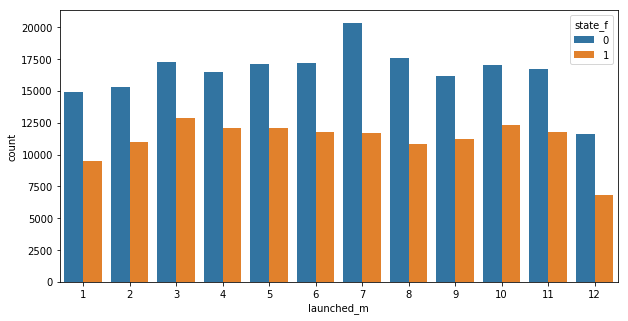

In [31]:
ks2['launched_m'] =ks2['launched'].dt.month
plt.figure(figsize=(10,5))
sns.countplot(data=ks2, x='launched_m',hue='state_f')

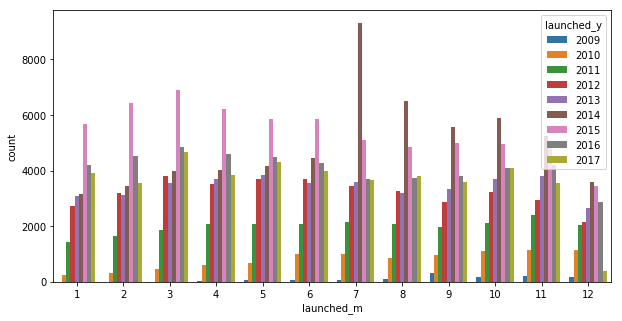

In [32]:
#年度ごとの各月の件数を可視化する。
ks2['launched_m'] =ks2['launched'].dt.month
plt.figure(figsize=(10,5))
sns.countplot(data=ks2, x='launched_m',hue='launched_y')

2014は7月に同時に10,000件近く開始している。

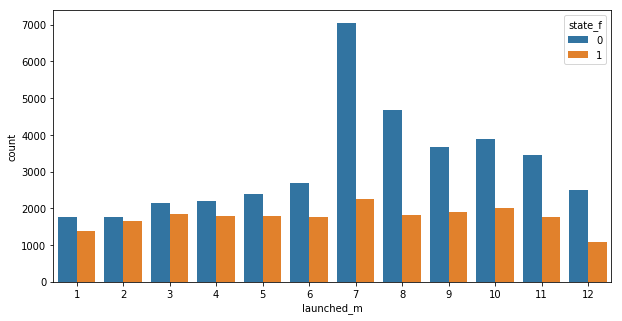

In [33]:
#2014年の各月の成否を可視化する。
plt.figure(figsize=(10,5))
sns.countplot( x='launched_m',hue='state_f',data=ks2[ks2['launched_y'].isin(['2014'])])

同時に開催されている件数が多いと成功率が低いと想定される。

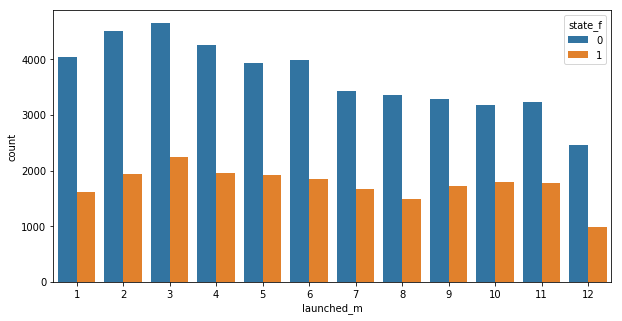

In [34]:
plt.figure(figsize=(10,5))
sns.countplot( x='launched_m',hue='state_f',data=ks2[ks2['launched_y'].isin(['2015'])])

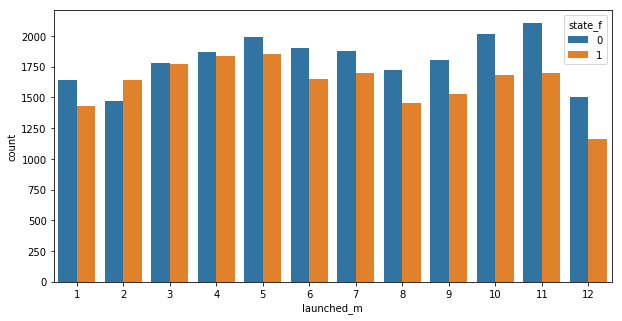

In [35]:
plt.figure(figsize=(10,5))
sns.countplot( x='launched_m',hue='state_f',data=ks2[ks2['launched_y'].isin(['2013'])])

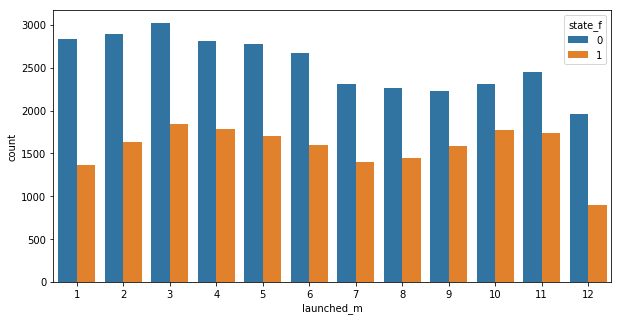

In [36]:
plt.figure(figsize=(10,5))
sns.countplot( x='launched_m',hue='state_f',data=ks2[ks2['launched_y'].isin(['2016'])])

同月開催数をカウントする。

カウンター値が同時開催件数になるが、変数として対応する行に代入する関数がわからない.
for文で作ることにする。

In [37]:
ks2['launched_ym'] = ks2['launched'].dt.strftime("%Y-%m")

In [38]:
launched = ks2['launched_ym'].value_counts()
launched = pd.DataFrame(launched)

In [39]:
c = 0
ks2['launched_ym_cnt'] = 0

for index,row in launched.iterrows():
    ym = index
    cnt = launched.loc[ym,'launched_ym']
    ks2.loc[ks2['launched_ym'] == ym, 'launched_ym_cnt'] = cnt
    c = c+1

print(c) 

105


In [40]:
ks2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 20 columns):
ID                 331675 non-null int64
name               331672 non-null object
category           331675 non-null object
main_category      331675 non-null object
currency           331675 non-null object
deadline           331675 non-null datetime64[ns]
goal               331675 non-null float64
launched           331675 non-null datetime64[ns]
state              331675 non-null object
country            331675 non-null object
usd_goal_real      331675 non-null float64
state_f            331675 non-null int64
name_len           331672 non-null float64
name_sp            331672 non-null float64
days               331675 non-null int64
launched_y         331675 non-null int64
usd_goal_log       331675 non-null float64
launched_m         331675 non-null int64
launched_ym        331675 non-null object
launched_ym_cnt    331675 non-null int64
dtypes: datetime64[ns](2), float64

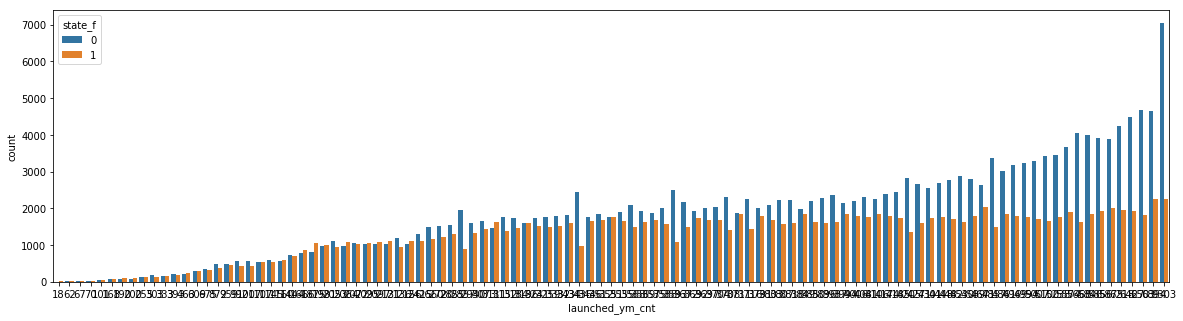

In [41]:
plt.figure(figsize=(20,5))
sns.countplot(data=ks2, x='launched_ym_cnt',hue='state_f')

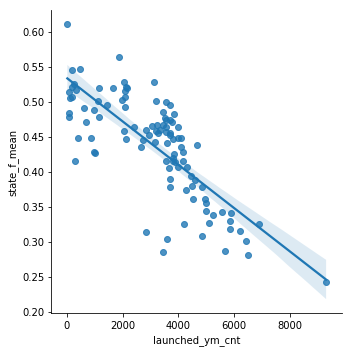

In [42]:
z = ks2.groupby(['launched_ym_cnt'],as_index=False).state_f.mean()
z =z.rename(columns={'state_f': 'state_f_mean'})
f_rate = sns.lmplot(x='launched_ym_cnt',y='state_f_mean',data=z)

同時期の開催数が多いと成功率が下がることが確認できた。  
説明変数に採用する。

#### countryとcurrencyについて
country（国）とcurrency（通貨）はほぼイコールと思われる。
どやって数値で証明するか？

In [43]:
ks2['country'].value_counts()

US      261360
GB       29454
CA       12370
AU        6616
DE        3436
FR        2520
NL        2411
IT        2369
ES        1873
SE        1509
MX        1411
NZ        1274
DK         926
IE         683
CH         652
NO         582
BE         523
AT         485
HK         477
SG         454
N,0"       210
LU          57
JP          23
Name: country, dtype: int64

In [44]:
#N,0"をNOに修正
ks2.loc[ks2['country'] == 'N,0"', 'country'] = 'NO'
ks2['country'].value_counts()

US    261360
GB     29454
CA     12370
AU      6616
DE      3436
FR      2520
NL      2411
IT      2369
ES      1873
SE      1509
MX      1411
NZ      1274
DK       926
NO       792
IE       683
CH       652
BE       523
AT       485
HK       477
SG       454
LU        57
JP        23
Name: country, dtype: int64

In [45]:
#currencyをダミー変数に変換
crcy = pd.get_dummies(ks2['currency'],dtype=int)
cr_cu = crcy
display(cr_cu.head())

,AUD,CAD,CHF,DKK,EUR,GBP,HKD,JPY,MXN,NOK,NZD,SEK,SGD,USD
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [46]:
#countryをダミー変数に変換
cnty = pd.get_dummies(ks2['country'],dtype=int)
cr_cu = pd.concat([cr_cu, cnty], axis=1)
display(cr_cu.head())

,AUD,CAD,CHF,DKK,EUR,GBP,HKD,JPY,MXN,NOK,...,IT,JP,LU,MX,NL,NO,NZ,SE,SG,US
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [47]:
cr_cu[['USD','GBP','CAD','US','GB','CA']].corr()

,USD,GBP,CAD,US,GB,CA
USD,1.000000,-0.602942,-0.380068,0.998637,-0.602695,-0.379988
GBP,-0.602942,1.000000,-0.061484,-0.602120,0.999590,-0.061471
CAD,-0.380068,-0.061484,1.000000,-0.379550,-0.061459,0.999790
US,0.998637,-0.602120,-0.379550,1.000000,-0.601874,-0.379470
GB,-0.602695,0.999590,-0.061459,-0.601874,1.000000,-0.061446
CA,-0.379988,-0.061471,0.999790,-0.379470,-0.061446,1.000000


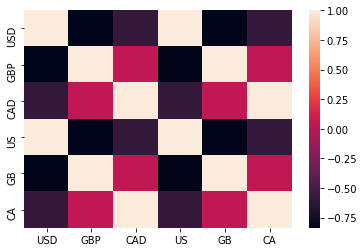

In [48]:
sns.heatmap(cr_cu[['USD','GBP','CAD','US','GB','CA']].corr().corr())
plt.show()

In [49]:
(ks2['currency'].value_counts()/ks2['currency'].count())*100

USD    78.845557
GBP     8.887013
EUR     4.334966
CAD     3.731062
AUD     1.996231
SEK     0.455265
MXN     0.425416
NZD     0.384111
DKK     0.280093
CHF     0.196578
NOK     0.176076
HKD     0.143815
SGD     0.136881
JPY     0.006934
Name: currency, dtype: float64

USDとUS,GBPとGB,CADとCAはそれぞれ0.99以上の相関でありほぼ同一である。（自国通貨を使用している）  
同様にEU圏はEURと想定される。
USDとGBとCADは全体の90%をしめており、説明変数としてはcurrencyとcountryどちらか一つでよいと思われる。  
今回は種類の少ないcurrencyを採用する。

In [50]:
ks2 = pd.concat([ks2, crcy], axis=1)

#### category,main_categoryについて
categoryは159種、main_categoryは15種類のためmain_categoryを説明変数として採用する。

In [51]:
ks2['main_category'].value_counts()

Film & Video    56527
Music           45949
Publishing      35445
Games           28521
Technology      27050
Art             25641
Design          25364
Food            22054
Fashion         19775
Theater         10242
Comics           9878
Photography      9689
Crafts           7818
Journalism       4149
Dance            3573
Name: main_category, dtype: int64

In [52]:
m_ctg = pd.get_dummies(ks2['main_category'],dtype=int)
ks2 = pd.concat([ks2, m_ctg], axis=1)
display(ks2.head())

,ID,name,category,main_category,currency,deadline,goal,launched,state,country,...,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,failed,GB,...,0,0,0,0,0,0,0,1,0,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,failed,US,...,0,1,0,0,0,0,0,0,0,0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,failed,US,...,0,1,0,0,0,0,0,0,0,0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,failed,US,...,0,0,0,0,0,1,0,0,0,0
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,successful,US,...,0,0,1,0,0,0,0,0,0,0


In [53]:
#'state'をTrue/Falseに変換する。
ks2['state'] = ks2['state'] == 'successful' 
display(ks2.head())

,ID,name,category,main_category,currency,deadline,goal,launched,state,country,...,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,False,GB,...,0,0,0,0,0,0,0,1,0,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,False,US,...,0,1,0,0,0,0,0,0,0,0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,False,US,...,0,1,0,0,0,0,0,0,0,0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,False,US,...,0,0,0,0,0,1,0,0,0,0
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,True,US,...,0,0,1,0,0,0,0,0,0,0


In [54]:
ks2['state'].value_counts()

False    197719
True     133956
Name: state, dtype: int64

In [55]:
ks2.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'state', 'country', 'usd_goal_real', 'state_f',
       'name_len', 'name_sp', 'days', 'launched_y', 'usd_goal_log',
       'launched_m', 'launched_ym', 'launched_ym_cnt', 'AUD', 'CAD', 'CHF',
       'DKK', 'EUR', 'GBP', 'HKD', 'JPY', 'MXN', 'NOK', 'NZD', 'SEK', 'SGD',
       'USD', 'Art', 'Comics', 'Crafts', 'Dance', 'Design', 'Fashion',
       'Film & Video', 'Food', 'Games', 'Journalism', 'Music', 'Photography',
       'Publishing', 'Technology', 'Theater'],
      dtype='object')

In [56]:
#不要な目的変数は削除する。
ks3 = ks2.drop(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
                'goal', 'launched', 'country', 'state_f', 'name_sp','launched_y','launched_m'
                ,'launched_ym'],axis=1)
display(ks3.head())

,state,usd_goal_real,name_len,days,usd_goal_log,launched_ym_cnt,AUD,CAD,CHF,DKK,...,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater
0,False,1533.95,31.0,58,7.335601,4857,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,False,30000.00,45.0,59,10.308953,3588,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,False,45000.00,14.0,44,10.714418,3073,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,False,5000.00,49.0,29,8.517193,3791,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,True,50000.00,20.0,34,10.819778,4530,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [57]:
ks3.isnull().sum()

state              0
usd_goal_real      0
name_len           3
days               0
usd_goal_log       0
launched_ym_cnt    0
AUD                0
CAD                0
CHF                0
DKK                0
EUR                0
GBP                0
HKD                0
JPY                0
MXN                0
NOK                0
NZD                0
SEK                0
SGD                0
USD                0
Art                0
Comics             0
Crafts             0
Dance              0
Design             0
Fashion            0
Film & Video       0
Food               0
Games              0
Journalism         0
Music              0
Photography        0
Publishing         0
Technology         0
Theater            0
dtype: int64

In [58]:
### 欠損地が3つあるため、欠損値を含む行を削除
ks3 = ks3.dropna()
ks3.isnull().sum()

state              0
usd_goal_real      0
name_len           0
days               0
usd_goal_log       0
launched_ym_cnt    0
AUD                0
CAD                0
CHF                0
DKK                0
EUR                0
GBP                0
HKD                0
JPY                0
MXN                0
NOK                0
NZD                0
SEK                0
SGD                0
USD                0
Art                0
Comics             0
Crafts             0
Dance              0
Design             0
Fashion            0
Film & Video       0
Food               0
Games              0
Journalism         0
Music              0
Photography        0
Publishing         0
Technology         0
Theater            0
dtype: int64

In [59]:
ks3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331672 entries, 0 to 378660
Data columns (total 35 columns):
state              331672 non-null bool
usd_goal_real      331672 non-null float64
name_len           331672 non-null float64
days               331672 non-null int64
usd_goal_log       331672 non-null float64
launched_ym_cnt    331672 non-null int64
AUD                331672 non-null int32
CAD                331672 non-null int32
CHF                331672 non-null int32
DKK                331672 non-null int32
EUR                331672 non-null int32
GBP                331672 non-null int32
HKD                331672 non-null int32
JPY                331672 non-null int32
MXN                331672 non-null int32
NOK                331672 non-null int32
NZD                331672 non-null int32
SEK                331672 non-null int32
SGD                331672 non-null int32
USD                331672 non-null int32
Art                331672 non-null int32
Comics             3316

***
### LASSOによる特徴選択

In [60]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

# estimatorにモデルをセット
# LassoCVを使って、正則化の強さは自動決定
estimator = LassoCV(normalize=True, cv=10)

# モデルの情報を使って特徴選択を行う場合は、SelectFromModelを使う
# 今回は係数が1e-5以下である特徴を削除する
# 係数のしきい値はthresholdで指定する
sfm = SelectFromModel(estimator, threshold=1e-5)

In [61]:
train_label = ks3["state"]
train_data = ks3.drop("state", axis=1)

y = train_label.values
X = train_data.values

In [62]:
# fitで特徴選択を実行
sfm.fit(X, y)

# Trueになっている特徴が使用する特徴
sfm.get_support()


array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [63]:
# 削除すべき特徴の名前を取得 
removed_idx  = ~sfm.get_support()
train_data.columns[removed_idx]

Index(['usd_goal_real', 'SGD', 'Art'], dtype='object')

In [64]:
ks3 = ks3.drop(['usd_goal_real', 'SGD', 'Art'],axis=1)

***
ロジスティック回帰により予測する。

In [65]:
y = ks3['state'].values
X = ks3.drop('state', axis=1).values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [66]:
# ラベルを予測
y_est = clf.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

対数尤度 = -13.946
正答率 = 59.622%


In [67]:
# 正答率を計算
accuracy =  accuracy_score(y, y_est)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)

# カテゴリ「stat」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

正答率（Accuracy） = 59.622%
適合率（Precision） = 50.008%
再現率（Recall） = 74.151%
F1値（F1-score） = 59.732%


In [68]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y, y_est)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
conf_mat

,予測 = failed,予測 = successful
正解 = failed,98419,99297
正解 = successful,34626,99330


***
ホールドアウト法を試す。

In [69]:
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.metrics import mean_absolute_error # 回帰問題における性能評価に関する関数

In [70]:
y = ks3['state'].values
X = ks3.drop('state', axis=1).values
test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test,y_train , y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）

***
パラメータの正規化/標準化を行う。

In [71]:
ks3.columns

Index(['state', 'name_len', 'days', 'usd_goal_log', 'launched_ym_cnt', 'AUD',
       'CAD', 'CHF', 'DKK', 'EUR', 'GBP', 'HKD', 'JPY', 'MXN', 'NOK', 'NZD',
       'SEK', 'USD', 'Comics', 'Crafts', 'Dance', 'Design', 'Fashion',
       'Film & Video', 'Food', 'Games', 'Journalism', 'Music', 'Photography',
       'Publishing', 'Technology', 'Theater'],
      dtype='object')

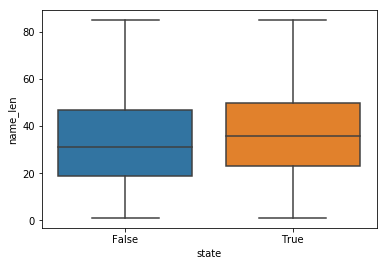

In [72]:
sns.boxplot(x="state", y="name_len", data=ks3)

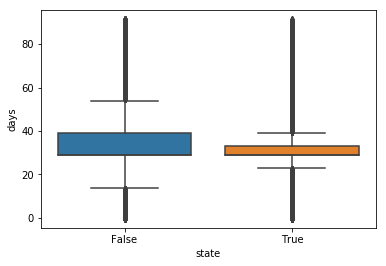

In [73]:
sns.boxplot(x="state", y="days", data=ks3)

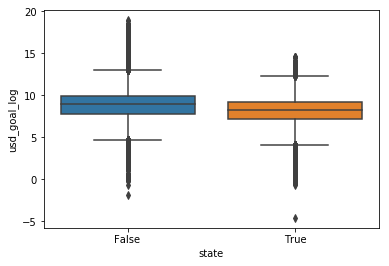

In [74]:
sns.boxplot(x="state", y="usd_goal_log", data=ks3)

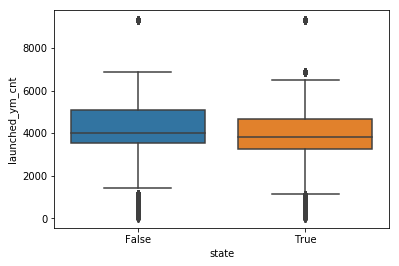

In [75]:
sns.boxplot(x="state", y="launched_ym_cnt", data=ks3)

標準化を行う

In [76]:
#標準化する。
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.fit_transform(X_test)

(array([10737., 38030., 49440., 40483., 36504., 38535., 41134.,  9490.,
          390.,   594.]),
 array([-2.08228569, -1.55582156, -1.02935742, -0.50289329,  0.02357085,
         0.55003498,  1.07649912,  1.60296325,  2.12942739,  2.65589153,
         3.18235566]),
 <a list of 10 Patch objects>)

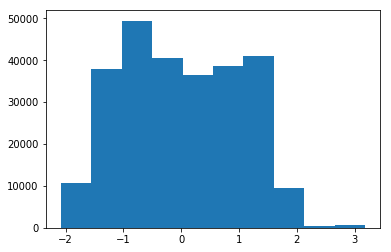

In [77]:
plt.hist(X_train_std[:, 0]) 

(array([  4997.,  13391.,  27499., 155486.,  28209.,   6565.,  26239.,
           563.,    401.,   1987.]),
 array([-2.59413718, -1.87786802, -1.16159885, -0.44532969,  0.27093947,
         0.98720864,  1.7034778 ,  2.41974696,  3.13601613,  3.85228529,
         4.56855445]),
 <a list of 10 Patch objects>)

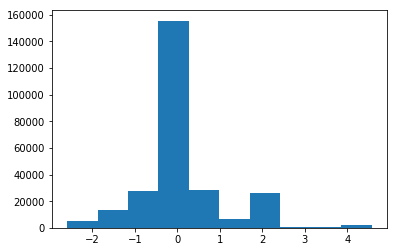

In [78]:
plt.hist(X_train_std[:, 1]) 

(array([2.56000e+02, 2.52000e+02, 2.06800e+03, 2.11090e+04, 9.24770e+04,
        1.20751e+05, 2.60280e+04, 2.06100e+03, 2.61000e+02, 7.40000e+01]),
 array([-6.26468269, -5.0251282 , -3.78557371, -2.54601922, -1.30646474,
        -0.06691025,  1.17264424,  2.41219873,  3.65175322,  4.89130771,
         6.1308622 ]),
 <a list of 10 Patch objects>)

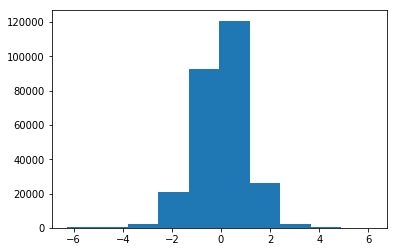

In [79]:
plt.hist(X_train_std[:, 2]) 

(array([ 3758.,  7566., 22768., 79228., 68896., 36273., 33906.,  5455.,
            0.,  7487.]),
 array([-2.6662987 , -2.07371949, -1.48114028, -0.88856106, -0.29598185,
         0.29659737,  0.88917658,  1.48175579,  2.07433501,  2.66691422,
         3.25949344]),
 <a list of 10 Patch objects>)

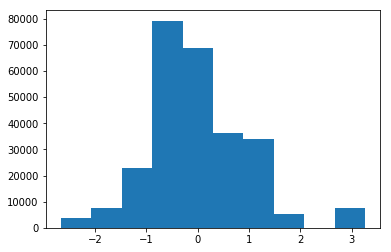

In [80]:
plt.hist(X_train_std[:, 3]) 

***
訓練データを使ってモデルを作成する。

In [81]:
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X_train_std, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [82]:
# 学習用データに対する予測を実行
y_pred_train = clf.predict(X_train_std)


In [83]:
# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_train,y_pred_train)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_train, y_pred_train)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, y_pred_train)

# カテゴリ「stat」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
conf_mat

対数尤度 = -11.893
正答率 = 65.566%
適合率（Precision） = 59.829%
再現率（Recall） = 44.883%
F1値（F1-score） = 51.289%


,予測 = failed,予測 = successful
正解 = failed,125871,32296
正解 = successful,59069,48101


In [84]:
# テストデータに対する予測を実行
y_pred_test = clf.predict(X_test_std)

In [85]:
# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test,y_pred_test)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_pred_test)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test,y_pred_test)

# カテゴリ「stat」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y_test,y_pred_test)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
conf_mat

対数尤度 = -12.017
正答率 = 65.208%
適合率（Precision） = 59.166%
再現率（Recall） = 44.665%
F1値（F1-score） = 50.903%


,予測 = failed,予測 = successful
正解 = failed,31292,8257
正解 = successful,14822,11964


訓練データのほうが正答率が高くやや過学習であるが  
問題ない範囲と思われる。

In [86]:
# グリットサーチ用に分割
test_size = 0.1
X_train_90, X_train_10, y_train_90, y_train_10 = train_test_split(X_train, y_train, test_size=test_size,random_state=1234)

In [87]:
# 標準化
stdsc = StandardScaler()
X_train_std10 = stdsc.fit_transform(X_train_10)

In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#パラメータを探索する。
parameters = {'n_estimators':[50,60,70,80,90,100], 'max_depth':[40,50,60],'min_samples_leaf':[5,10,15],'min_samples_split':[2,3]}
model = RandomForestClassifier(criterion="gini",random_state=1234)

gcv = GridSearchCV(model, parameters, cv=3,verbose=2)
gcv.fit(X_train_std10, y_train_10)
print(gcv.best_params_, gcv.best_score_)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] max_depth=40, min_samples_leaf=5, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=40, min_samples_leaf=5, min_samples_split=2, n_estimators=50, total=   1.1s
[CV] max_depth=40, min_samples_leaf=5, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV]  max_depth=40, min_samples_leaf=5, min_samples_split=2, n_estimators=50, total=   1.1s
[CV] max_depth=40, min_samples_leaf=5, min_samples_split=2, n_estimators=50 
[CV]  max_depth=40, min_samples_leaf=5, min_samples_split=2, n_estimators=50, total=   1.1s
[CV] max_depth=40, min_samples_leaf=5, min_samples_split=2, n_estimators=60 
[CV]  max_depth=40, min_samples_leaf=5, min_samples_split=2, n_estimators=60, total=   1.3s
[CV] max_depth=40, min_samples_leaf=5, min_samples_split=2, n_estimators=60 
[CV]  max_depth=40, min_samples_leaf=5, min_samples_split=2, n_estimators=60, total=   1.3s
[CV] max_depth=40, min_samples_leaf=5, min_samples_split=2, n_estimators=60 
[CV]  max_depth=40, min_samples_leaf=5, min_samples_split=2, n_estimators=60, total=   1.3s
[CV] max_depth=40, min_samples_leaf=5, min_samples_split=2, n_estimators=70 
[CV]  max_depth=40, min_samples_leaf=5, min_samples_split=2, n_estimators=70, total=   1.6s
[CV] max_depth=40, min_samples_leaf=5, min_samples_split=2, n_e

[CV]  max_depth=40, min_samples_leaf=10, min_samples_split=2, n_estimators=90, total=   1.8s
[CV] max_depth=40, min_samples_leaf=10, min_samples_split=2, n_estimators=100 
[CV]  max_depth=40, min_samples_leaf=10, min_samples_split=2, n_estimators=100, total=   2.0s
[CV] max_depth=40, min_samples_leaf=10, min_samples_split=2, n_estimators=100 
[CV]  max_depth=40, min_samples_leaf=10, min_samples_split=2, n_estimators=100, total=   2.0s
[CV] max_depth=40, min_samples_leaf=10, min_samples_split=2, n_estimators=100 
[CV]  max_depth=40, min_samples_leaf=10, min_samples_split=2, n_estimators=100, total=   2.0s
[CV] max_depth=40, min_samples_leaf=10, min_samples_split=3, n_estimators=50 
[CV]  max_depth=40, min_samples_leaf=10, min_samples_split=3, n_estimators=50, total=   1.0s
[CV] max_depth=40, min_samples_leaf=10, min_samples_split=3, n_estimators=50 
[CV]  max_depth=40, min_samples_leaf=10, min_samples_split=3, n_estimators=50, total=   1.0s
[CV] max_depth=40, min_samples_leaf=10, min_sa

[CV]  max_depth=40, min_samples_leaf=15, min_samples_split=3, n_estimators=70, total=   1.2s
[CV] max_depth=40, min_samples_leaf=15, min_samples_split=3, n_estimators=80 
[CV]  max_depth=40, min_samples_leaf=15, min_samples_split=3, n_estimators=80, total=   1.5s
[CV] max_depth=40, min_samples_leaf=15, min_samples_split=3, n_estimators=80 
[CV]  max_depth=40, min_samples_leaf=15, min_samples_split=3, n_estimators=80, total=   1.5s
[CV] max_depth=40, min_samples_leaf=15, min_samples_split=3, n_estimators=80 
[CV]  max_depth=40, min_samples_leaf=15, min_samples_split=3, n_estimators=80, total=   1.5s
[CV] max_depth=40, min_samples_leaf=15, min_samples_split=3, n_estimators=90 
[CV]  max_depth=40, min_samples_leaf=15, min_samples_split=3, n_estimators=90, total=   1.7s
[CV] max_depth=40, min_samples_leaf=15, min_samples_split=3, n_estimators=90 
[CV]  max_depth=40, min_samples_leaf=15, min_samples_split=3, n_estimators=90, total=   1.7s
[CV] max_depth=40, min_samples_leaf=15, min_samples_

[CV]  max_depth=50, min_samples_leaf=10, min_samples_split=2, n_estimators=60, total=   1.1s
[CV] max_depth=50, min_samples_leaf=10, min_samples_split=2, n_estimators=60 
[CV]  max_depth=50, min_samples_leaf=10, min_samples_split=2, n_estimators=60, total=   1.2s
[CV] max_depth=50, min_samples_leaf=10, min_samples_split=2, n_estimators=60 
[CV]  max_depth=50, min_samples_leaf=10, min_samples_split=2, n_estimators=60, total=   1.2s
[CV] max_depth=50, min_samples_leaf=10, min_samples_split=2, n_estimators=70 
[CV]  max_depth=50, min_samples_leaf=10, min_samples_split=2, n_estimators=70, total=   1.4s
[CV] max_depth=50, min_samples_leaf=10, min_samples_split=2, n_estimators=70 
[CV]  max_depth=50, min_samples_leaf=10, min_samples_split=2, n_estimators=70, total=   1.4s
[CV] max_depth=50, min_samples_leaf=10, min_samples_split=2, n_estimators=70 
[CV]  max_depth=50, min_samples_leaf=10, min_samples_split=2, n_estimators=70, total=   1.4s
[CV] max_depth=50, min_samples_leaf=10, min_samples_

[CV]  max_depth=50, min_samples_leaf=15, min_samples_split=2, n_estimators=100, total=   1.9s
[CV] max_depth=50, min_samples_leaf=15, min_samples_split=2, n_estimators=100 
[CV]  max_depth=50, min_samples_leaf=15, min_samples_split=2, n_estimators=100, total=   1.9s
[CV] max_depth=50, min_samples_leaf=15, min_samples_split=2, n_estimators=100 
[CV]  max_depth=50, min_samples_leaf=15, min_samples_split=2, n_estimators=100, total=   1.8s
[CV] max_depth=50, min_samples_leaf=15, min_samples_split=3, n_estimators=50 
[CV]  max_depth=50, min_samples_leaf=15, min_samples_split=3, n_estimators=50, total=   0.9s
[CV] max_depth=50, min_samples_leaf=15, min_samples_split=3, n_estimators=50 
[CV]  max_depth=50, min_samples_leaf=15, min_samples_split=3, n_estimators=50, total=   0.9s
[CV] max_depth=50, min_samples_leaf=15, min_samples_split=3, n_estimators=50 
[CV]  max_depth=50, min_samples_leaf=15, min_samples_split=3, n_estimators=50, total=   0.9s
[CV] max_depth=50, min_samples_leaf=15, min_sam

[CV]  max_depth=70, min_samples_leaf=5, min_samples_split=3, n_estimators=80, total=   1.8s
[CV] max_depth=70, min_samples_leaf=5, min_samples_split=3, n_estimators=80 
[CV]  max_depth=70, min_samples_leaf=5, min_samples_split=3, n_estimators=80, total=   1.8s
[CV] max_depth=70, min_samples_leaf=5, min_samples_split=3, n_estimators=90 
[CV]  max_depth=70, min_samples_leaf=5, min_samples_split=3, n_estimators=90, total=   2.1s
[CV] max_depth=70, min_samples_leaf=5, min_samples_split=3, n_estimators=90 
[CV]  max_depth=70, min_samples_leaf=5, min_samples_split=3, n_estimators=90, total=   2.0s
[CV] max_depth=70, min_samples_leaf=5, min_samples_split=3, n_estimators=90 
[CV]  max_depth=70, min_samples_leaf=5, min_samples_split=3, n_estimators=90, total=   2.0s
[CV] max_depth=70, min_samples_leaf=5, min_samples_split=3, n_estimators=100 
[CV]  max_depth=70, min_samples_leaf=5, min_samples_split=3, n_estimators=100, total=   2.3s
[CV] max_depth=70, min_samples_leaf=5, min_samples_split=3, n

[CV]  max_depth=70, min_samples_leaf=15, min_samples_split=2, n_estimators=60, total=   1.1s
[CV] max_depth=70, min_samples_leaf=15, min_samples_split=2, n_estimators=60 
[CV]  max_depth=70, min_samples_leaf=15, min_samples_split=2, n_estimators=60, total=   1.1s
[CV] max_depth=70, min_samples_leaf=15, min_samples_split=2, n_estimators=70 
[CV]  max_depth=70, min_samples_leaf=15, min_samples_split=2, n_estimators=70, total=   1.3s
[CV] max_depth=70, min_samples_leaf=15, min_samples_split=2, n_estimators=70 
[CV]  max_depth=70, min_samples_leaf=15, min_samples_split=2, n_estimators=70, total=   1.3s
[CV] max_depth=70, min_samples_leaf=15, min_samples_split=2, n_estimators=70 
[CV]  max_depth=70, min_samples_leaf=15, min_samples_split=2, n_estimators=70, total=   1.2s
[CV] max_depth=70, min_samples_leaf=15, min_samples_split=2, n_estimators=80 
[CV]  max_depth=70, min_samples_leaf=15, min_samples_split=2, n_estimators=80, total=   1.5s
[CV] max_depth=70, min_samples_leaf=15, min_samples_

[CV]  max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, total=   2.3s
[CV] max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100 
[CV]  max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, total=   2.3s
[CV] max_depth=100, min_samples_leaf=5, min_samples_split=3, n_estimators=50 
[CV]  max_depth=100, min_samples_leaf=5, min_samples_split=3, n_estimators=50, total=   1.1s
[CV] max_depth=100, min_samples_leaf=5, min_samples_split=3, n_estimators=50 
[CV]  max_depth=100, min_samples_leaf=5, min_samples_split=3, n_estimators=50, total=   1.1s
[CV] max_depth=100, min_samples_leaf=5, min_samples_split=3, n_estimators=50 
[CV]  max_depth=100, min_samples_leaf=5, min_samples_split=3, n_estimators=50, total=   1.1s
[CV] max_depth=100, min_samples_leaf=5, min_samples_split=3, n_estimators=60 
[CV]  max_depth=100, min_samples_leaf=5, min_samples_split=3, n_estimators=60, total=   1.3s
[CV] max_depth=100, min_samples_leaf=5, min_sampl

[CV]  max_depth=100, min_samples_leaf=10, min_samples_split=3, n_estimators=80, total=   1.6s
[CV] max_depth=100, min_samples_leaf=10, min_samples_split=3, n_estimators=80 
[CV]  max_depth=100, min_samples_leaf=10, min_samples_split=3, n_estimators=80, total=   1.5s
[CV] max_depth=100, min_samples_leaf=10, min_samples_split=3, n_estimators=90 
[CV]  max_depth=100, min_samples_leaf=10, min_samples_split=3, n_estimators=90, total=   1.8s
[CV] max_depth=100, min_samples_leaf=10, min_samples_split=3, n_estimators=90 
[CV]  max_depth=100, min_samples_leaf=10, min_samples_split=3, n_estimators=90, total=   1.8s
[CV] max_depth=100, min_samples_leaf=10, min_samples_split=3, n_estimators=90 
[CV]  max_depth=100, min_samples_leaf=10, min_samples_split=3, n_estimators=90, total=   1.7s
[CV] max_depth=100, min_samples_leaf=10, min_samples_split=3, n_estimators=100 
[CV]  max_depth=100, min_samples_leaf=10, min_samples_split=3, n_estimators=100, total=   2.0s
[CV] max_depth=100, min_samples_leaf=10

[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed: 14.0min finished


{'max_depth': 40, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 80} 0.6680862289892214


導き出されたパラメータを使って予測する。

In [90]:
clf = RandomForestClassifier(n_estimators=80, max_depth=40, criterion="gini",min_samples_leaf=10, min_samples_split=2, random_state=1234)
clf.fit(X_train_std, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=40, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False)

In [91]:
# 学習用データに対する予測を実行
y_pred_train = clf.predict(X_train_std)

In [92]:
# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_train,y_pred_train)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_train, y_pred_train)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, y_pred_train)

# カテゴリ「stat」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
conf_mat

対数尤度 = -9.548
正答率 = 72.355%
適合率（Precision） = 70.438%
再現率（Recall） = 54.375%
F1値（F1-score） = 61.373%


,予測 = failed,予測 = successful
正解 = failed,133710,24457
正解 = successful,48896,58274


In [93]:
# テストデータに対する予測を実行
y_pred_test = clf.predict(X_test_std)

In [94]:
# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test,y_pred_test)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_pred_test)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test,y_pred_test)

# カテゴリ「stat」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y_test,y_pred_test)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
conf_mat

対数尤度 = -11.254
正答率 = 67.415%
適合率（Precision） = 62.603%
再現率（Recall） = 47.947%
F1値（F1-score） = 54.303%


,予測 = failed,予測 = successful
正解 = failed,31877,7672
正解 = successful,13943,12843


### まとめ

Day1  

|手法|標準化|対数尤度|正答率|適合率（Precision）|再現率（Recall）|F1値（F1-score）|ホールドアウト法|
|-|-|-|-|-|-|-|-|
|ロジスティック回帰|なし|-14.026|59.392%|66.766%|0.694%|1.373%|なし|
  
Day2  

|手法|標準化|対数尤度|正答率|適合率（Precision）|再現率（Recall）|F1値（F1-score）|ホールドアウト法|
|-|-|-|-|-|-|-|-|
|ロジスティック回帰|あり|-11.975|65.330%|58.660%|47.949%|52.766%|なし|
|ロジスティック回帰|あり*|-12.026|65.180%|60.687%|39.158%|47.602%|訓練データ|
|ロジスティック回帰|あり*|-12.094|64.984%|60.133%|39.412%|47.616%|テストデータ|
|SVM|あり|-13.101|62.070%|55.816%|29.205%|38.346%|なし|
  
  
\*:テスト／訓練データ分割前に正規化、標準化してしまった。

Day3  
  
|手法|標準化|対数尤度|正答率|適合率（Precision）|再現率（Recall）|F1値（F1-score）|ホールドアウト法|
|-|-|-|-|-|-|-|-|
|ロジスティック回帰|なし|-13.946|59.622%|50.008%|74.151%|59.732%|なし|
|ロジスティック回帰|あり|-11.893|65.566%|59.829%|44.883%|51.289%|訓練データ|
|ロジスティック回帰|あり|-12.014|65.216%|59.180%|44.669%|50.911%|テストデータ|
|ランダムフォレスト|あり|-9.548|72.355%|70.438%|54.375%|61.373%|訓練データ|
|ランダムフォレスト|あり|-11.254|67.415%|62.603%|47.947%|54.303%|テストデータ|


ランダムフォレストは過学習しているためパラメータ調整の必要あり  
時間切れのため後日実施